In [1]:
#importing libraries
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
import torch
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
mpl.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading Dataset

We are going to look at the original dataset for “ECG5000” which is a 20-hour long ECG downloaded from Physionet. 
<br><br>
An LSTM Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture. For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence. <br><br>
**To classify a sequence as normal or an anomaly, we’ll pick a threshold above which a heartbeat is considered abnormal.**

In [3]:
with open('./data/ECG5000_TRAIN.arff') as f:
    raw_data = loadarff(f)
    train_data = pd.DataFrame(raw_data[0])


with open('./data/ECG5000_TEST.arff') as f:
    raw_data = loadarff(f)
    test_data = pd.DataFrame(raw_data[0])
    
train_data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.478577,-1.779959,-2.398159,-3.170112,-3.559732,-3.573956,-2.989770,-2.270605,-1.688277,-1.359872,...,1.160885,1.456331,2.209421,2.507175,2.198534,1.705849,1.492642,1.561890,1.520161,b'4'
496,-1.325210,-2.480992,-2.965356,-3.342392,-3.176351,-2.891528,-2.369679,-1.598750,-1.071751,-0.891843,...,-0.172154,-0.864803,-1.549854,-2.460243,-3.366562,-3.466546,-2.718380,-1.855209,-1.539958,b'4'
497,-0.021964,-0.912434,-1.903353,-2.662829,-3.122156,-3.451490,-3.392982,-2.929937,-2.256294,-1.690706,...,1.339479,1.457995,2.128078,2.630759,2.295748,1.764967,1.444280,1.432347,1.457028,b'4'
498,0.288011,-1.098020,-2.500250,-3.598599,-3.650608,-3.281587,-2.231601,-1.250656,-1.072574,-0.434310,...,-0.029242,0.071414,0.118161,-0.071967,-0.171214,0.131211,0.049872,0.010915,-0.081534,b'5'


In [4]:
test_data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,b'1'
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,b'1'
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,b'1'
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,b'1'
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4'
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2'
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2'
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2'


In [5]:
df = train_data.append(test_data)
df.shape

C:\Users\kusha\AppData\Local\Temp\ipykernel_1740\2531296656.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train_data.append(test_data)


(5000, 141)

The dataset contains 5,000 Time Series examples with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure. 
<br><br>
We have 5 types of heartbeats (classes):
1. Normal (N)
2. Premature Ventricular Contraction (PVC)
3. R-on-T Premature Ventricular Contraction (R-on-T PVC)
4. Supra-ventricular Premature or Ectopic Beat (SP or EB)
5. Unclassified Beat (UB).

In [6]:
class_names = ['Normal', 'PVC', 'R or T', 'SP', 'UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [7]:
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4'
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2'
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2'
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2'


In [8]:
df.target.value_counts()

b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: target, dtype: int64

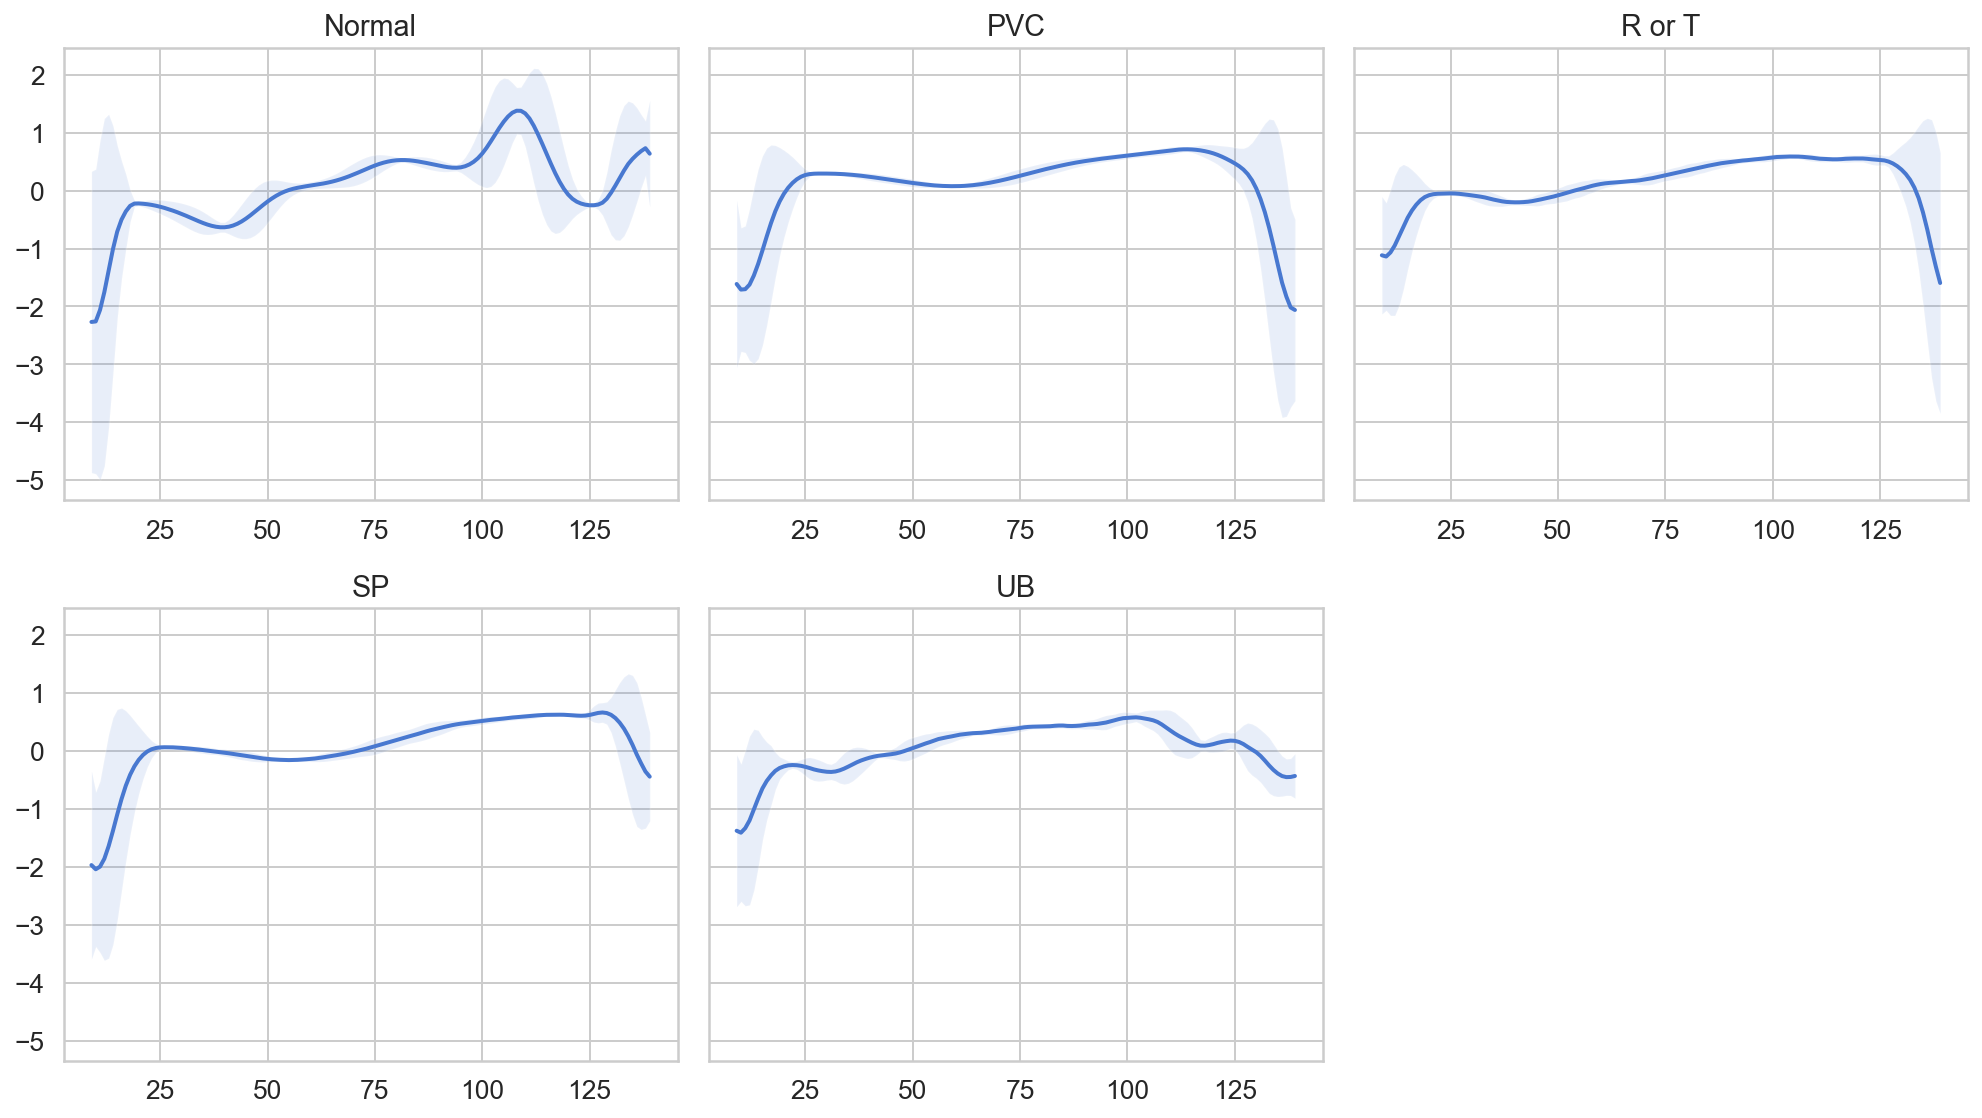

In [9]:
# averaged time-series data for each class.
def plot_data(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125)
    ax.set_title(class_name)
    
classes = df.target.unique()
fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_data(data, class_names[i], ax)
fig.delaxes(axs.flat[-1])
fig.tight_layout();

The normal class has distinctly different patterns than other patterns.
<br><br>
**In our Anomaly Detection in ECG Data, We’ll use normal heartbeats as training data for our model and record the reconstruction loss.**

In [10]:
normal_df = df[df['target'] == b'1'].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [11]:
anomaly_df = df[df['target'] != b'1'].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [12]:
#Train, validation and test sets for normal data for model training
train_data, val_data = train_test_split(normal_df, test_size=0.20, random_state=RANDOM_SEED)
val_data, test_data = train_test_split(val_data, test_size=0.30, random_state=RANDOM_SEED)

In [13]:
 train_data.shape, val_data.shape, test_data.shape

((2335, 140), (408, 140), (176, 140))

In [14]:
#Tensors of training data
def create_dataset(df):
    # Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [15]:
train_dataset, seq_len, n_features = create_dataset(train_data)
val_dataset, _, _ = create_dataset(val_data)
test_normal_dataset, _, _ = create_dataset(test_data)
test_abnormal_dataset, _, _ = create_dataset(anomaly_df)

### AutoEncoder Model

Autoencoders try to reduce the dimensionality of the dataset and increase the dimensionality through autoencoding. During the reconstruction phase, the model tries to reconstruct the heartbeat data normally. As we provide the anomaly data to the model, the reconstruction error is high as the error is propagated showing the anomalies which are what we are looking for.

In [16]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
      # Initializing the hidden numbers of layers
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
        
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [17]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        #Using a dense layer as an output layer
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [18]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [19]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [20]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())


        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
    
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [21]:
model,history = train_model(model,train_dataset,val_dataset,n_epochs=50)

Epoch 1: train loss 98.24752044677734 val loss 58.91298582974602
Epoch 2: train loss 101.15092468261719 val loss 57.18281625298893
Epoch 3: train loss 101.55602264404297 val loss 56.61481372047873
Epoch 4: train loss 101.9930191040039 val loss 56.26089064280192
Epoch 5: train loss 102.21463775634766 val loss 56.0909484835232
Epoch 6: train loss 102.465576171875 val loss 55.91364240178875
Epoch 7: train loss 96.41705322265625 val loss 102.5558089835971
Epoch 8: train loss 96.41029357910156 val loss 46.75038060019998
Epoch 9: train loss 85.74884796142578 val loss 37.24172715579762
Epoch 10: train loss 92.94395446777344 val loss 33.43869274036557
Epoch 11: train loss 66.6514663696289 val loss 29.09824977201574
Epoch 12: train loss 49.16215133666992 val loss 26.939275972983417
Epoch 13: train loss 47.98217010498047 val loss 27.158494056439867
Epoch 14: train loss 51.76388168334961 val loss 25.69400930404663
Epoch 15: train loss 48.151275634765625 val loss 27.851483300620433
Epoch 16: train

After training, we get Training loss at 16.15 and Validation loss at 14.85

Prediction function to predict sequences from our model

In [22]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
        
            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

The function goes through each datapoint and calculates the prediction(using the model) and the loss.

C:\Users\kusha\AppData\Local\Temp\ipykernel_1740\1153265548.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


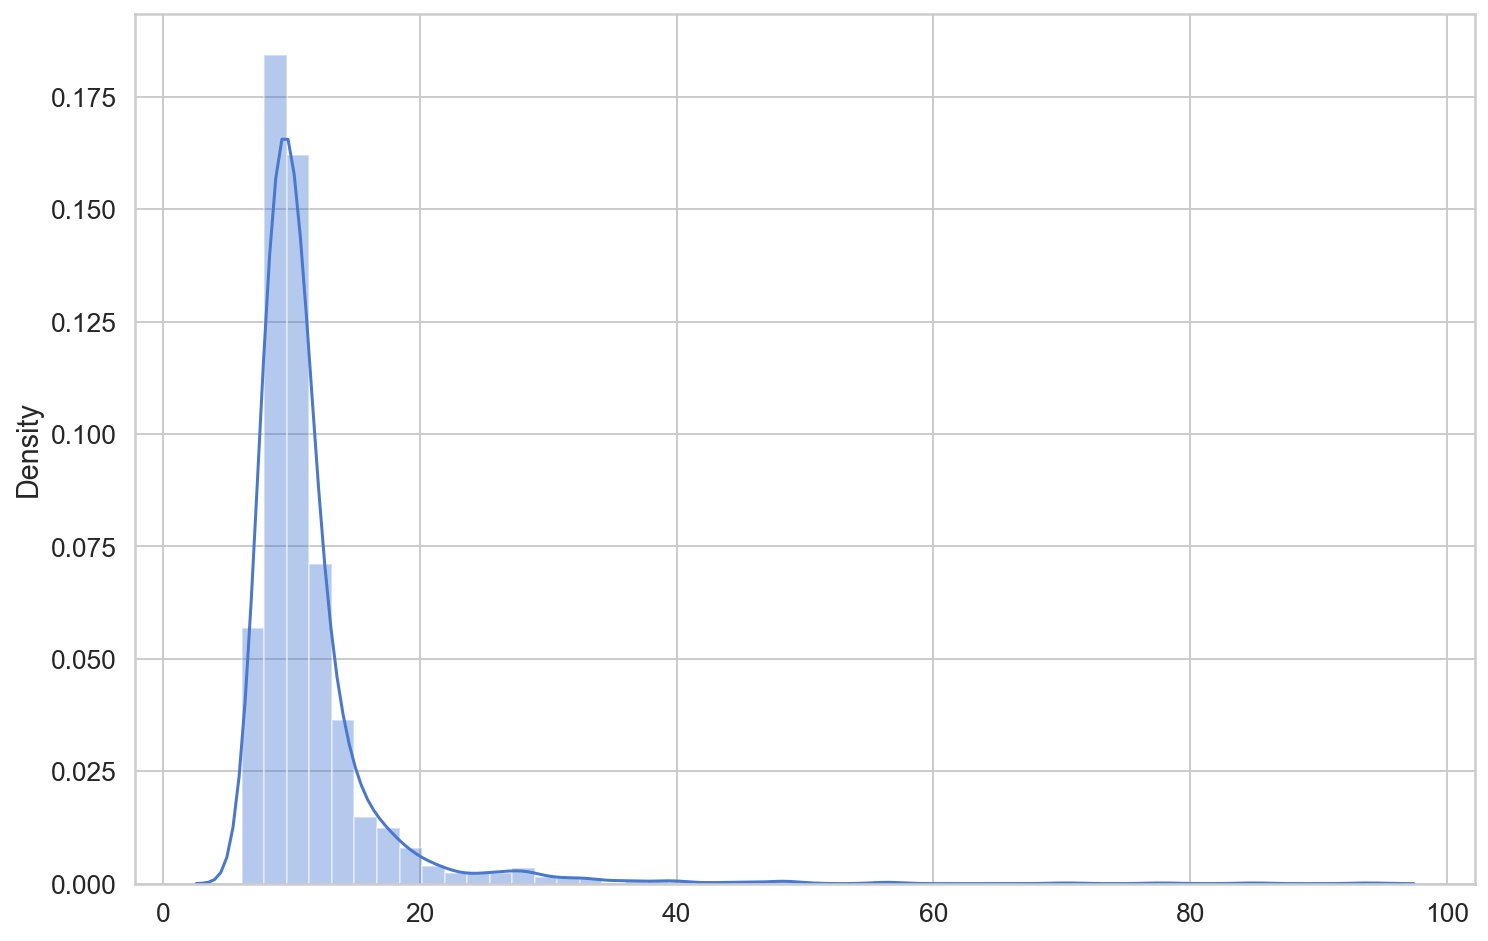

In [23]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

Using the threshold, the problem is converted into a binary classification problem. <br><br>
**If the reconstruction loss is below the threshold, the heartbeat is classified as normal heartbeat, and if the reconstruction loss is higher than the threshold, the heartbeat is classified as abnormal heartbeat**

C:\Users\kusha\AppData\Local\Temp\ipykernel_1740\2828554042.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True)


<AxesSubplot: ylabel='Density'>

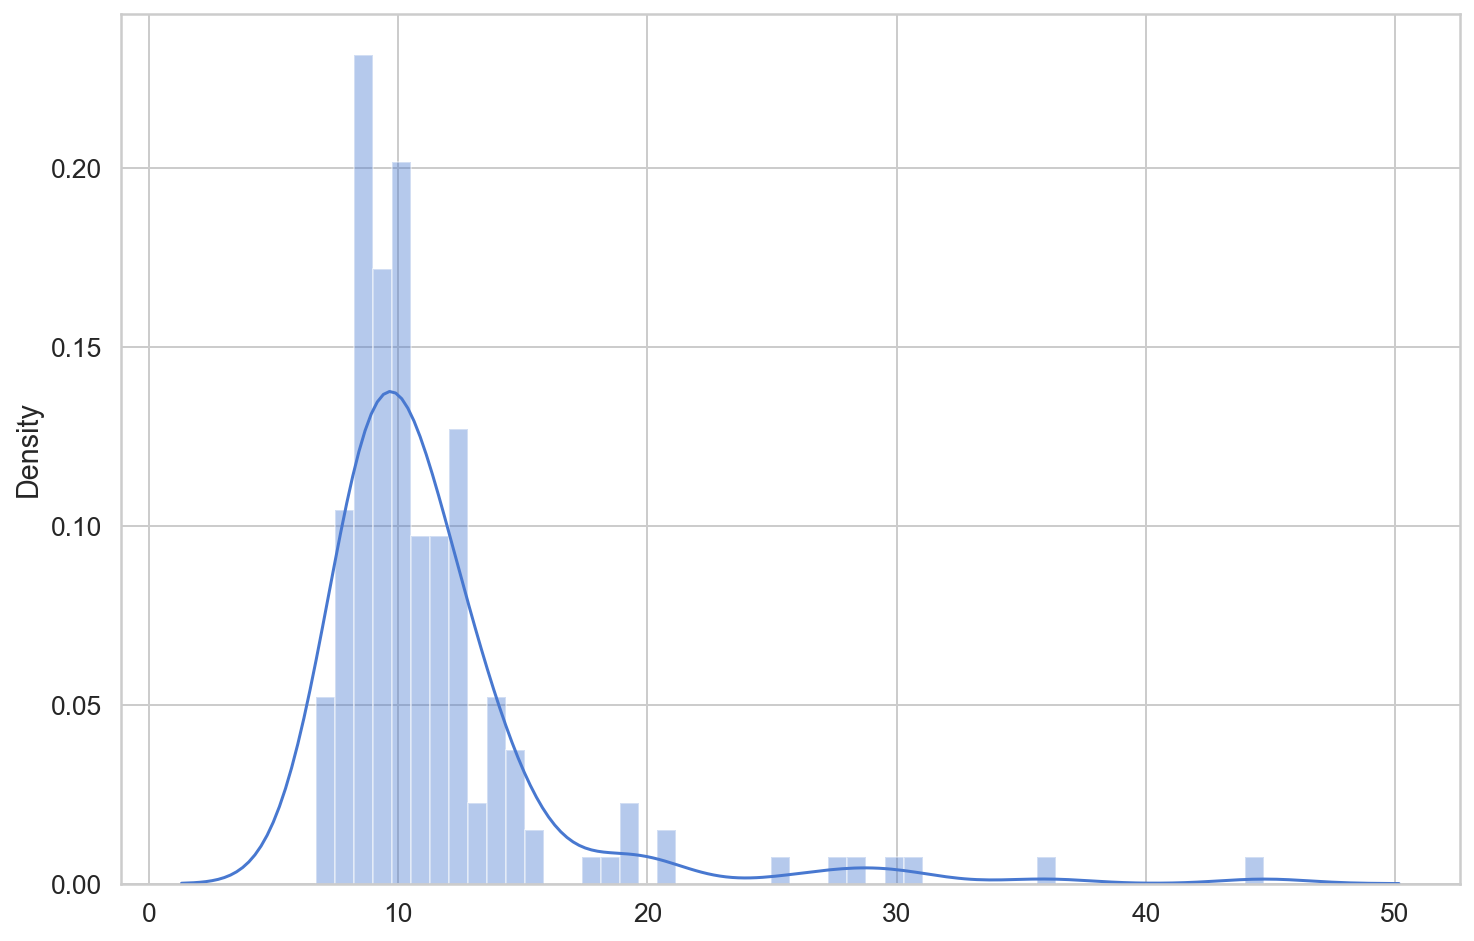

In [34]:
THRESHOLD = 26
#Predictions on test dataset of normal heartbeat
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [35]:
correct_preds = sum(loss <= THRESHOLD for loss in pred_losses)
print(f'Correct normal heartbeat predictions: {correct_preds}/{len(test_normal_dataset)}')

Correct normal heartbeat predictions: 170/176


C:\Users\kusha\AppData\Local\Temp\ipykernel_1740\3966768144.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True)


<AxesSubplot: ylabel='Density'>

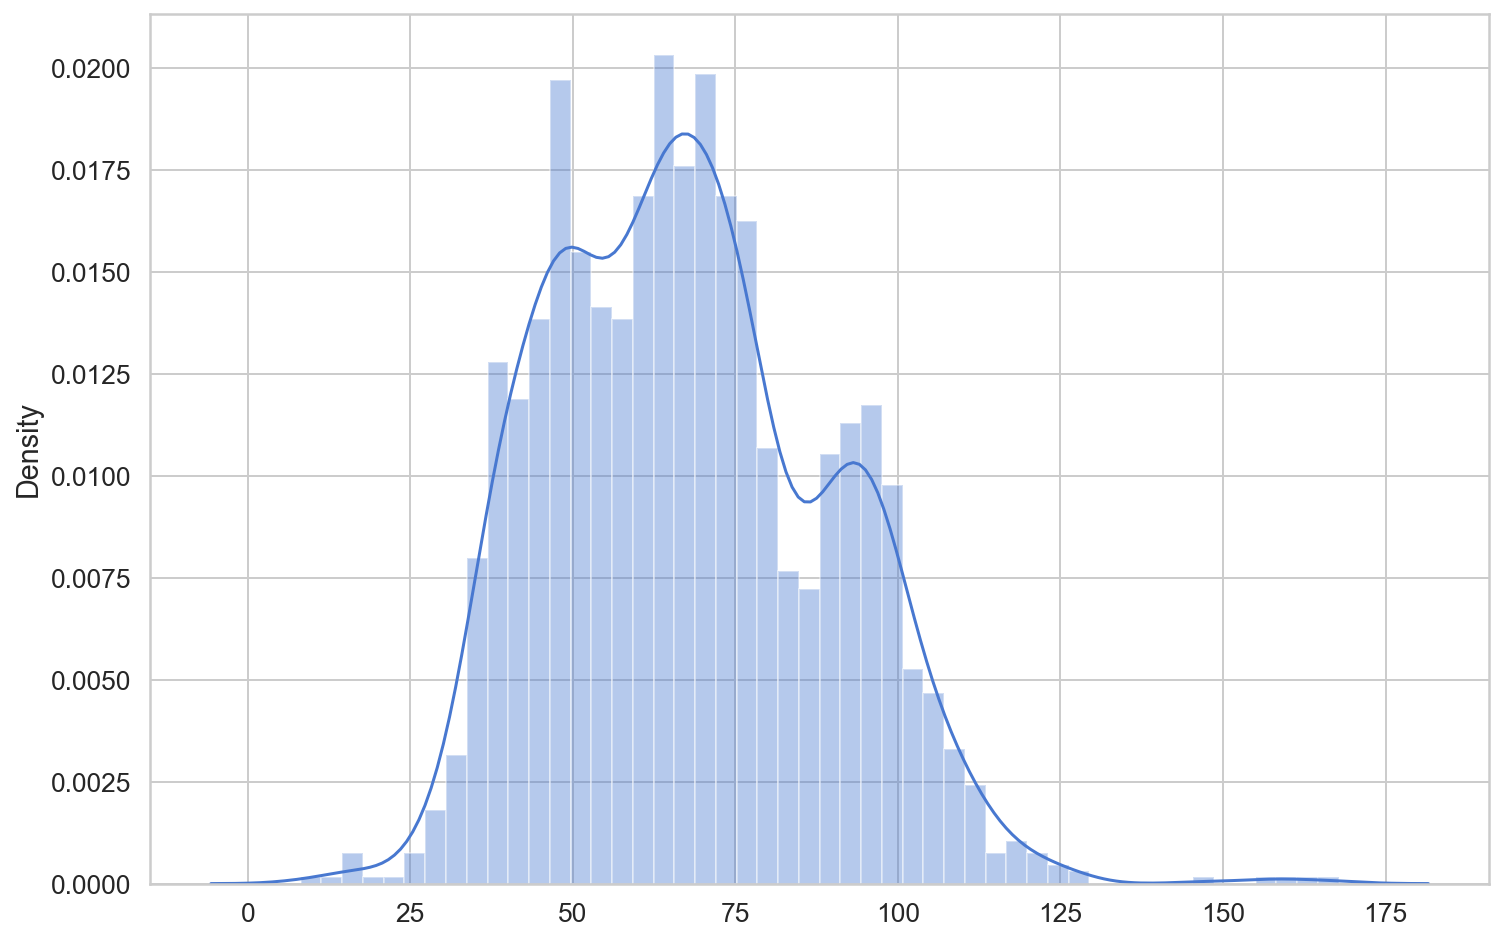

In [36]:
#for abnormal heartbeat dataset
predictions, pred_losses = predict(model, test_abnormal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [39]:
correct_preds_abnormal = sum(loss > THRESHOLD for loss in pred_losses)
print(f'Correct abnormal heartbeat predictions: {correct_preds_abnormal}/{len(test_abnormal_dataset)}')

Correct abnormal heartbeat predictions: 2069/2081


Overlaying the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [42]:
def plot_preds(data, model, title, ax):
    preds, pred_losses = predict(model, [data])
    ax.plot(data, label='True')
    ax.plot(preds[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()
    plt.plot()

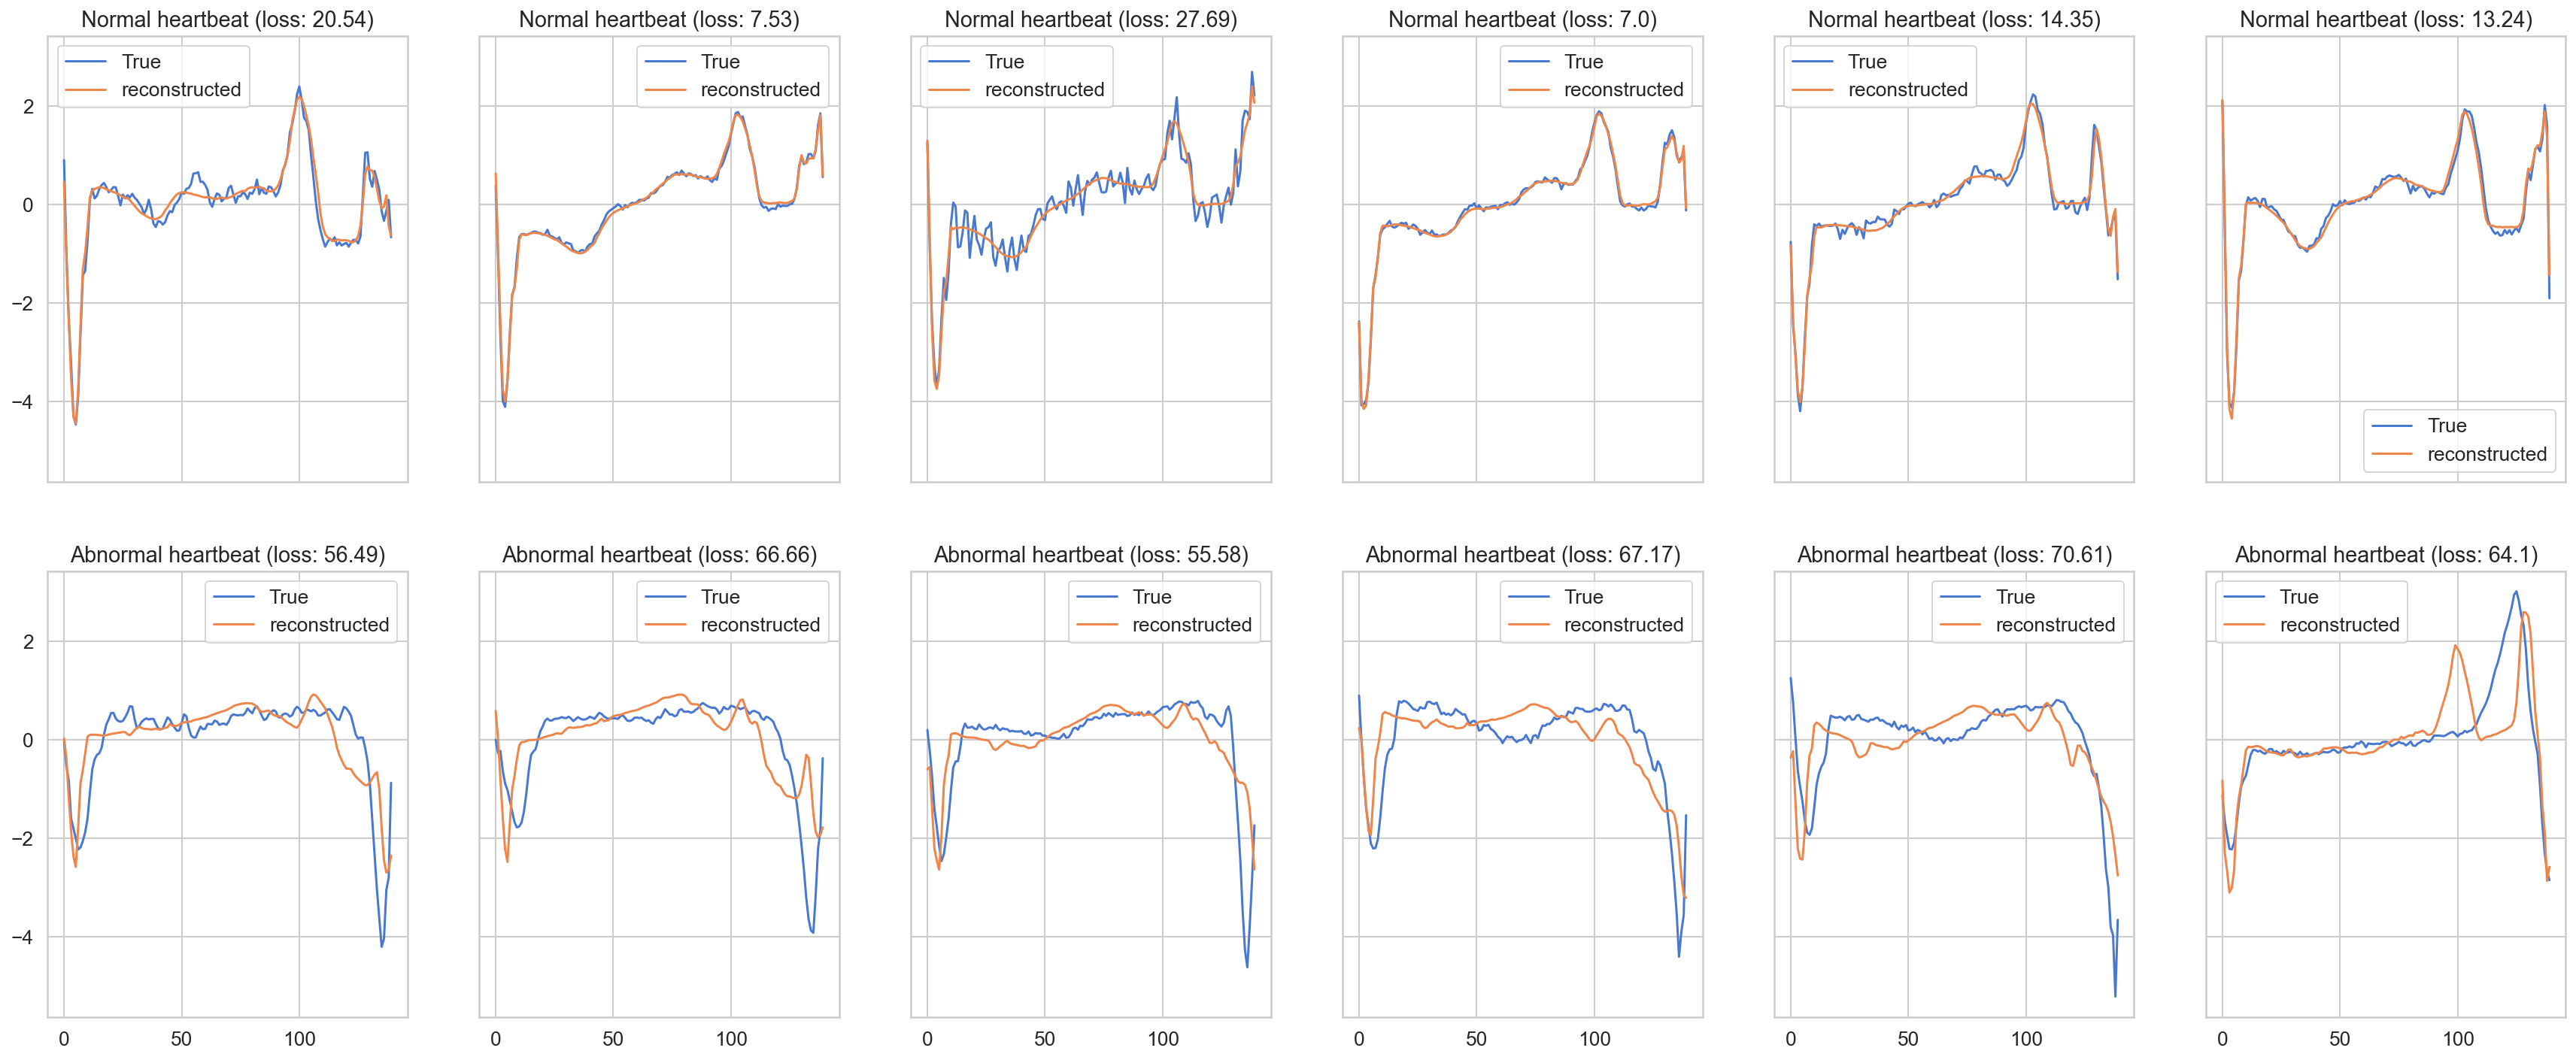

In [45]:
figs, axes = plt.subplots(nrows=2, ncols=6, sharey=True, sharex=True, figsize=(30, 12))
for i, data in enumerate(test_normal_dataset[:6]):
    plot_preds(data, model, title='Normal heartbeat', ax=axes[0, i])

for i, data in enumerate(test_abnormal_dataset[:6]):
    plot_preds(data, model, title='Abnormal heartbeat', ax=axes[1, i])

fig.tight_layout()

**We can see that normal heartbeat is very well classified and abnormal heartbeat are not so, because the model was trained on normal heartbeats only.**<br><br>
Thus our model is performing very well.